# Data preperation for a public health organisation

## Data Processing

This notebook outlines the data processing steps for analyzing the Open Food Facts dataset. The workflow is divided into three key stages:
1. **Data quality and description**: Assessing the dataset's completeness and structure.
2. **Data cleaning**: Refining the dataset by removing inconsistencies and selecting relevant indicators.
3. **Data organization**: Structuring the cleaned data for analysis.

The output of this notebook includes a processed dataframe, ready for exploratory analysis.

## Instructions for use

1. Download the Open Food Facts French dataset on the official website https://world.openfoodfacts.org
2. Update the file paths in the code below to match your local directory structure.

In [1]:
# File paths [update with your file path]
data_path_raw = (
    '/Users/nataschajademinnitt/Documents/5. Data Analysis/'
    'open_classrooms/project_3/data/raw/'
)

data_path_processed = (
    '/Users/nataschajademinnitt/Documents/5. Data Analysis/'
    'open_classrooms/project_3/data/processed/'
)

figures_path = (
    '/Users/nataschajademinnitt/Documents/5. Data Analysis/'
    'open_classrooms/project_3/results/figures/'
)

## Part 1: Clean and filter the features and products

### Load data

In [70]:
# Import libraries
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Set environment
pd.set_option('display.float_format', '{:.1f}'.format)
sns.set_theme(style="whitegrid", context="paper")

In [5]:
# Load the file
raw = pd.read_csv(data_path_raw + 'fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
raw.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [7]:
# Shape of the dataframe
nRow, nCol = raw.shape
dtype_counts = raw.dtypes.value_counts()
duplicated = raw.duplicated().sum()

print(f'There are {nRow} rows of which {duplicated} are duplicated.\n')
print(f'There are {nCol} columns which include:\n{dtype_counts}\n')

There are 320772 rows of which 0 are duplicated.

There are 162 columns which include:
float64    106
object      56
Name: count, dtype: int64



### Filter

#### Tecnhical approach
1. Identify a reference feature with more than 50% missing data, drop na for this feature.
2. Remove empty columns with more than 90% of their data misisng.

In [9]:
# Identify a categorical variable
object_columns = raw.select_dtypes(include=['object'])

missing_percentages = (object_columns.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame(missing_percentages, columns=['Missing Percentage']).reset_index()

missing_df.columns = ['Column', 'Missing Percentage']

missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)

missing_df = missing_df[(missing_df['Missing Percentage'] > 50) & (missing_df['Missing Percentage'] < 80)]

print(missing_df)

# Select pnns_groups_1 as a reference
df_filter = raw.copy()
df_filter = df_filter[df_filter['pnns_groups_1'].notnull()]

              Column  Missing Percentage
22         image_url                76.4
23   image_small_url                76.4
24    packaging_tags                75.4
25         packaging                75.4
26  main_category_fr                73.7
27     main_category                73.7
28     categories_fr                73.7
29        categories                73.7
30   categories_tags                73.7
31     pnns_groups_1                71.5
32     pnns_groups_2                70.5
33          quantity                67.3
34      additives_fr                51.8
35    additives_tags                51.8


In [11]:
# Drop columns with all NaN values
na_columns = df_filter.columns[df_filter.isnull().all()]

print(f"Columns with 100% missing values: {len(na_columns)}")
print(na_columns)

df_filter = df_filter.drop(columns=na_columns)

Columns with 100% missing values: 21
Index(['cities', 'allergens_fr', 'no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk',
       'butyric-acid_100g', 'caproic-acid_100g', 'behenic-acid_100g',
       'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g',
       'dihomo-gamma-linolenic-acid_100g', 'elaidic-acid_100g',
       'gondoic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g',
       'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object')


In [13]:
# Drop floats with > 90 missing values
float_columns = df_filter.select_dtypes(include=['float64'])

columns_to_drop = float_columns.columns[float_columns.isnull().mean() > 0.60]

df_filter = df_filter.drop(columns=columns_to_drop)

# Result
print(f"Dropped columns: {len(columns_to_drop)}")
print(f"Remaining columns: {df_filter.columns}")

Dropped columns: 73
Remaining columns: Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr',
       'origins', 'origins_tags', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo',
       'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'allergens',
       'traces', 'traces_tags', 'traces_fr', 'serving_size', 'additives_n',
       'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_fr',
       'pnns_gro

#### Business approach
1. Keep only products that are consumed in France.
2. Select features that inform the nutritional quality of products.

In [15]:
# Filter rows for products in France using countries_fr
dropped = df_filter[~df_filter['countries_fr'].str.contains('France', na=False, case=False)]
num_dropped = len(dropped)

# Rows to keep
df_filter = df_filter[df_filter['countries_fr'].str.contains('France', na=False, case=False)]
num_kept = len(df_filter)

# Result
proportion_dropped = num_dropped / (num_dropped + num_kept)
print(f"Dropped rows: {num_dropped} ({proportion_dropped:.0%})")
print(f"Kept rows: {num_kept}")

Dropped rows: 26632 (29%)
Kept rows: 64881


In [17]:
# Select columns of interest
selected_columns = {
    # Product identification
    'product_name',
    'brands',
    # Product categorization
    'pnns_groups_1',
    'nutrition_grade_fr',
    # Nutritional information
    ## Negative if high 
    'saturated-fat_100g',
    'sugars_100g', 
    'sodium_100g',
    ## Positive if high
    'fiber_100g', 
    'proteins_100g',
    # Calulate energy score (caloric content per 100g)
    'fat_100g',
    'carbohydrates_100g',
    'energy_100g', # represented in kilojoules
    }

df_filter = df_filter[list(selected_columns)]

order = [
    'product_name',
    'brands',
    'pnns_groups_1',
    'nutrition_grade_fr',
    'saturated-fat_100g',
    'sugars_100g', 
    'sodium_100g',
    'fiber_100g', 
    'proteins_100g',
    'fat_100g',
    'carbohydrates_100g',
    'energy_100g',
]

df_filter = df_filter[order]

# Filter out rows where product_name or brands isna()
df_filter = df_filter[df_filter['product_name'].notnull()]
df_filter = df_filter[df_filter['brands'].notnull()]

# Consolidate the pnns_group categories
df_filter['pnns_groups_1'] = df_filter['pnns_groups_1'].replace({
    'fruits-and-vegetables': 'Fruits and vegetables',
    'sugary-snacks': 'Sugary snacks',
    'cereals-and-potatoes': 'Cereals and potatoes'
})

df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62614 entries, 106 to 320765
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        62614 non-null  object 
 1   brands              62614 non-null  object 
 2   pnns_groups_1       62614 non-null  object 
 3   nutrition_grade_fr  46735 non-null  object 
 4   saturated-fat_100g  47667 non-null  float64
 5   sugars_100g         47782 non-null  float64
 6   sodium_100g         47843 non-null  float64
 7   fiber_100g          31301 non-null  float64
 8   proteins_100g       49520 non-null  float64
 9   fat_100g            46669 non-null  float64
 10  carbohydrates_100g  46239 non-null  float64
 11  energy_100g         49778 non-null  float64
dtypes: float64(8), object(4)
memory usage: 6.2+ MB


## Part 2: Identify and treat outliers

### Validate nutritional totals
The following values are considered outliers:
1. The nutritional value for a single product should not exceed 100g
2. The energy_100g should not exceed 3,770 kJ/100g (the theoretical maximum energy density for food based on macronutrient values)

The corresponding rows are removed from the dataframe.

In [234]:
df = df_filter.copy()
print(f"Number of rows in the dataframe: {df.shape[0]}")
df.describe()

Number of rows in the dataframe: 62614


,saturated-fat_100g,sugars_100g,sodium_100g,fiber_100g,proteins_100g,fat_100g,carbohydrates_100g,energy_100g
count,47667.0,47782.0,47843.0,31301.0,49520.0,46669.0,46239.0,49778.0
mean,5.3,13.0,0.4,2.7,7.6,13.3,27.7,1165.8
std,8.2,18.6,1.6,4.1,7.5,16.9,27.4,14611.9
min,0.0,-0.1,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.3,1.0,0.0,0.3,1.7,1.3,4.0,410.0
50%,1.9,4.0,0.2,1.7,6.0,6.8,14.5,1011.0
75%,7.3,16.5,0.5,3.5,10.8,21.0,53.0,1636.0
max,210.0,105.0,83.0,178.0,100.0,380.0,190.0,3251373.0


In [236]:
# Identify rows where all nutritional values are NaN
nan_zero = (df.iloc[:, 4:12].isna()) | (df.iloc[:, 4:12] == 0)
rows_to_drop = nan_zero.all(axis=1)
print(f"# Rows where all nutritional values are either NaN or 0: {rows_to_drop.sum()}")

# Drop these rows from the dataframe
df = df[~rows_to_drop]
print(f"Number of rows after removing rows with all NaN or 0 nutritional values: {df.shape[0]}")

# Rows where all nutritional values are either NaN or 0: 12328
Number of rows after removing rows with all NaN or 0 nutritional values: 50286


In [238]:
# Identify rows with any negative values in nutritional columns
negative_values = df.iloc[:, 4:12] < 0
any_negative = negative_values.any(axis=1)
print(f"# Rows with negative values in any column: {any_negative.sum()}")

# Drop these rows from the dataframe
df = df[~any_negative]
print(f"Number of rows after removing all NaNs: {df.shape[0]}")

# Rows with negative values in any column: 1
Number of rows after removing all NaNs: 50285


In [240]:
# Set maximum theoretical thresholds for nutrients in 100g
thresholds = {
    'saturated-fat_100g': 35,
    'sugars_100g': 90,
    'sodium_100g': 5,
    'fiber_100g': 90,
    'proteins_100g': 90,
    'fat_100g': 100,
    'carbohydrates_100g': 100,
    'energy_100g': 3700
}

# Filter based on threshold
for nutrient, upper_limit in thresholds.items():
    if nutrient in df.columns:
        before_count = len(df)
        df = df[df[nutrient].isna() | (df[nutrient] <= upper_limit)]
        after_count = len(df)
        print(f"Rows removed after filtering {nutrient}: {before_count - after_count}")

print(f"\nNumber of rows after filtering: {len(df)}")

Rows removed after filtering saturated-fat_100g: 437
Rows removed after filtering sugars_100g: 224
Rows removed after filtering sodium_100g: 327
Rows removed after filtering fiber_100g: 3
Rows removed after filtering proteins_100g: 2
Rows removed after filtering fat_100g: 1
Rows removed after filtering carbohydrates_100g: 1
Rows removed after filtering energy_100g: 98

Number of rows after filtering: 49192


In [242]:
# Identify rows where saturated fat exceeds total fat
saturated_exceeds_fat = df['saturated-fat_100g'] > df['fat_100g']
print(f'# Rows where saturated fat is > total fat: {saturated_exceeds_fat.sum()}')

# Set saturated fat equal to fat
df.loc[saturated_exceeds_fat, 'saturated-fat_100g'] = df.loc[saturated_exceeds_fat, 'fat_100g']

# Rows where saturated fat is > total fat: 68


In [244]:
# Identify rows where sugars exceed total carbohydrates
sugars_exceeds_carbs = df['sugars_100g'] > df['carbohydrates_100g']
print(f'# Rows where sugars exceed total carbohydrates: {sugars_exceeds_carbs.sum()}')

# Set sugars equal to carbohydrates
df.loc[sugars_exceeds_carbs, 'sugars_100g'] = df.loc[sugars_exceeds_carbs, 'carbohydrates_100g']

# Rows where sugars exceed total carbohydrates: 84


In [246]:
# Handing fiber missing values and outliers
df['fiber_100g_new'] = df['fiber_100g']

# Replace NaN values with 0
df['fiber_100g_new'] = df['fiber_100g_new'].fillna(0)
fiber_na = df['fiber_100g'].isna().sum()
print(f'# Rows where fiber is NaN replaced with 0: {fiber_na}')

# Rows where fiber is NaN replaced with 0: 18615


In [248]:
# Nutritional columns
nutritional_cols = ['proteins_100g', 'fat_100g', 'carbohydrates_100g', 
                    'fiber_100g', 'sodium_100g']

# Calculate the sum of these nutritional components
nutrition_sum = df[nutritional_cols].sum(axis=1)

# Identify rows where the sum exceeds 100g
sum_exceeds_100g = nutrition_sum > 100
print(f"# Rows with summed nutrition composition exceeding 100g: {sum_exceeds_100g.sum()}")

# Drop these rows from the dataframe
df = df[~sum_exceeds_100g]
print(f"Number of rows after removing all NaNs: {df.shape[0]}")

# Rows with summed nutrition composition exceeding 100g: 326
Number of rows after removing all NaNs: 48866


### Validate corresponding scores

Energy (kJ/100g) should equal the following equation based on the Atwater factors:
* Fat: 37 kJ per gram
* Protein: 17 kJ per gram
* Carbohydrate: 17 kJ per gram

In France fiber is not included in the energy calculation.

In [251]:
subset = df.copy()
# Identifying rows with 0 / NAN energy_100g and energy macronutrients
mask = (subset.iloc[:, 8:12].isna() | (subset.iloc[:, 8:12] == 0)).all(axis=1)

# Replacing NANs with 0 (assuming it's food without any energy output)
subset.loc[mask, subset.columns[8:12]] = subset.loc[mask, subset.columns[8:12]].fillna(0)

In [253]:
# Calculate energy based on macronutrients
subset['energy_calculated'] = (
    subset['fat_100g'] * 37 +
    subset['proteins_100g'] * 17 +
    subset['carbohydrates_100g'] * 17
)

# Calculate the difference between energy_100g and calculated energy
subset['energy_diff'] = subset['energy_100g'] - subset['energy_calculated']

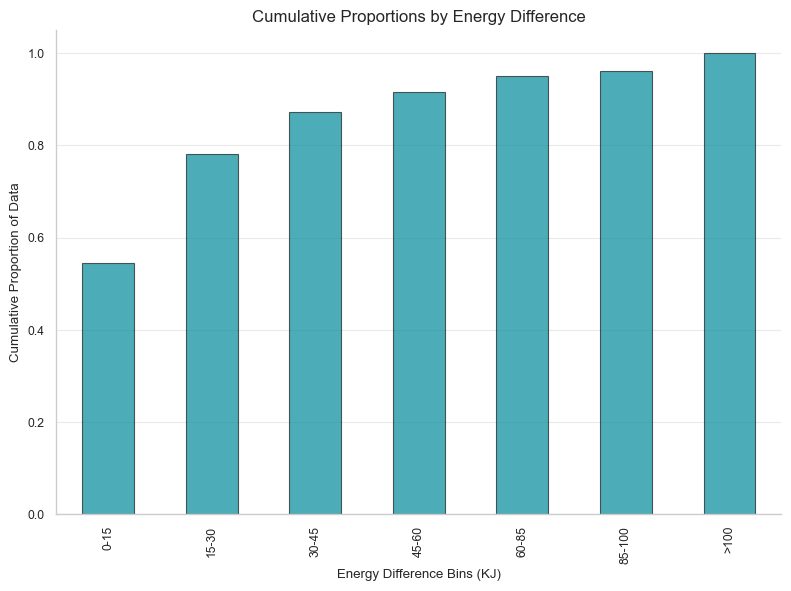

In [255]:
# Group energy_diff into bins
bins = [0, 15, 30, 45, 60, 85, 100, float('inf')]
labels = ['0-15', '15-30', '30-45', '45-60', '60-85', '85-100', '>100']
subset['energy_diff_bin'] = pd.cut(subset['energy_diff'].abs(), bins=bins, labels=labels, right=False)

# Calculate the cumulative proportions
bin_proportions = subset['energy_diff_bin'].value_counts(normalize=True).sort_index()
cumulative_proportions = bin_proportions.cumsum()

# Plot
plt.figure(figsize=(8, 6))
cumulative_proportions.plot(kind='bar', color='#008b9a', edgecolor='k', alpha=0.7)
plt.title('Cumulative Proportions by Energy Difference', fontsize=12)
plt.xlabel('Energy Difference Bins (KJ)')
plt.ylabel('Cumulative Proportion of Data')
sns.despine(top=True, right=True)
plt.grid(False, axis='x')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.savefig(figures_path + 'energy_diff_bins.png', dpi=300, bbox_inches='tight')
plt.show()

Assumption: energy_100g is less eroneous as it's a single value that requires completion and that fat_100g, proteins_100g, and carbohydrates_100g are more error-prone as they can be misunderstood, confused with other nutrients and are not prominent on the label. Therefore, recalculating the macronutrients so that their combined energy contribution matches the declared energy value (energy_100g).

In [257]:
# recalculating the energy score based on ratios
alpha = subset['energy_100g'] / subset['energy_calculated']

subset['fat_100g_new'] = alpha * subset['fat_100g']
subset['proteins_100g_new'] = alpha * subset['proteins_100g']
subset['carbohydrates_100g_new'] = alpha * subset['carbohydrates_100g']

In [259]:
# Checking the imputation
subset['energy_new'] = (
    subset['fat_100g_new'] * 37 +
    subset['proteins_100g_new'] * 17 +
    subset['carbohydrates_100g_new'] * 17
)

# Calculate the difference between energy_100g and calculated energy
subset['energy_diff_after'] = subset['energy_100g'] - subset['energy_new']

# Check the differences
subset['energy_diff_after'].describe()

count   44418.0
mean        0.0
std         0.0
min        -0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: energy_diff_after, dtype: float64

In [261]:
# Remove rows that exceed 100g after imputation
nutritional_cols = ['proteins_100g_new', 'fat_100g_new', 'carbohydrates_100g_new', 
                    'fiber_100g', 'sodium_100g']

# Calculate the sum of these nutritional components
nutrition_sum = subset[nutritional_cols].sum(axis=1)

# Identify rows where the sum exceeds 100g
sum_exceeds_100g = nutrition_sum > 100
print(f"# Rows with summed nutrition composition exceeding 100g: {sum_exceeds_100g.sum()}")

# Drop these rows from the dataframe
subset = subset[~sum_exceeds_100g]
print(f"Number of rows after removing all NaNs: {df.shape[0]}")

# Rows with summed nutrition composition exceeding 100g: 499
Number of rows after removing all NaNs: 48866


In [263]:
# Drop new columns
subset = subset.drop(columns=['fiber_100g',
                              'proteins_100g', 
                              'fat_100g', 
                              'carbohydrates_100g', 
                              'energy_calculated', 
                              'energy_diff', 
                              'energy_diff_bin', 
                              'energy_new',
                             'energy_diff_after'])

# Rename new columns
subset.rename(columns=lambda x: x.replace('_new', ''), inplace=True)

# Reorder columns
order = [
    'product_name',
    'brands',
    'pnns_groups_1',
    'nutrition_grade_fr',
    'saturated-fat_100g',
    'sugars_100g', 
    'sodium_100g',
    'fiber_100g', 
    'proteins_100g',
    'fat_100g',
    'carbohydrates_100g',
    'energy_100g',
]

subset = subset[order]
subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48367 entries, 106 to 320763
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        48367 non-null  object 
 1   brands              48367 non-null  object 
 2   pnns_groups_1       48367 non-null  object 
 3   nutrition_grade_fr  44840 non-null  object 
 4   saturated-fat_100g  45726 non-null  float64
 5   sugars_100g         45836 non-null  float64
 6   sodium_100g         45879 non-null  float64
 7   fiber_100g          48367 non-null  float64
 8   proteins_100g       43919 non-null  float64
 9   fat_100g            43919 non-null  float64
 10  carbohydrates_100g  43919 non-null  float64
 11  energy_100g         47926 non-null  float64
dtypes: float64(8), object(4)
memory usage: 4.8+ MB


## Part 3: Identify and Treat Missing Values

### Missing values

Percentage of Missing Values:
product_name         0.0
brands               0.0
pnns_groups_1        0.0
nutrition_grade_fr   7.3
saturated-fat_100g   5.5
sugars_100g          5.2
sodium_100g          5.1
fiber_100g           0.0
proteins_100g        9.2
fat_100g             9.2
carbohydrates_100g   9.2
energy_100g          0.9
dtype: float64


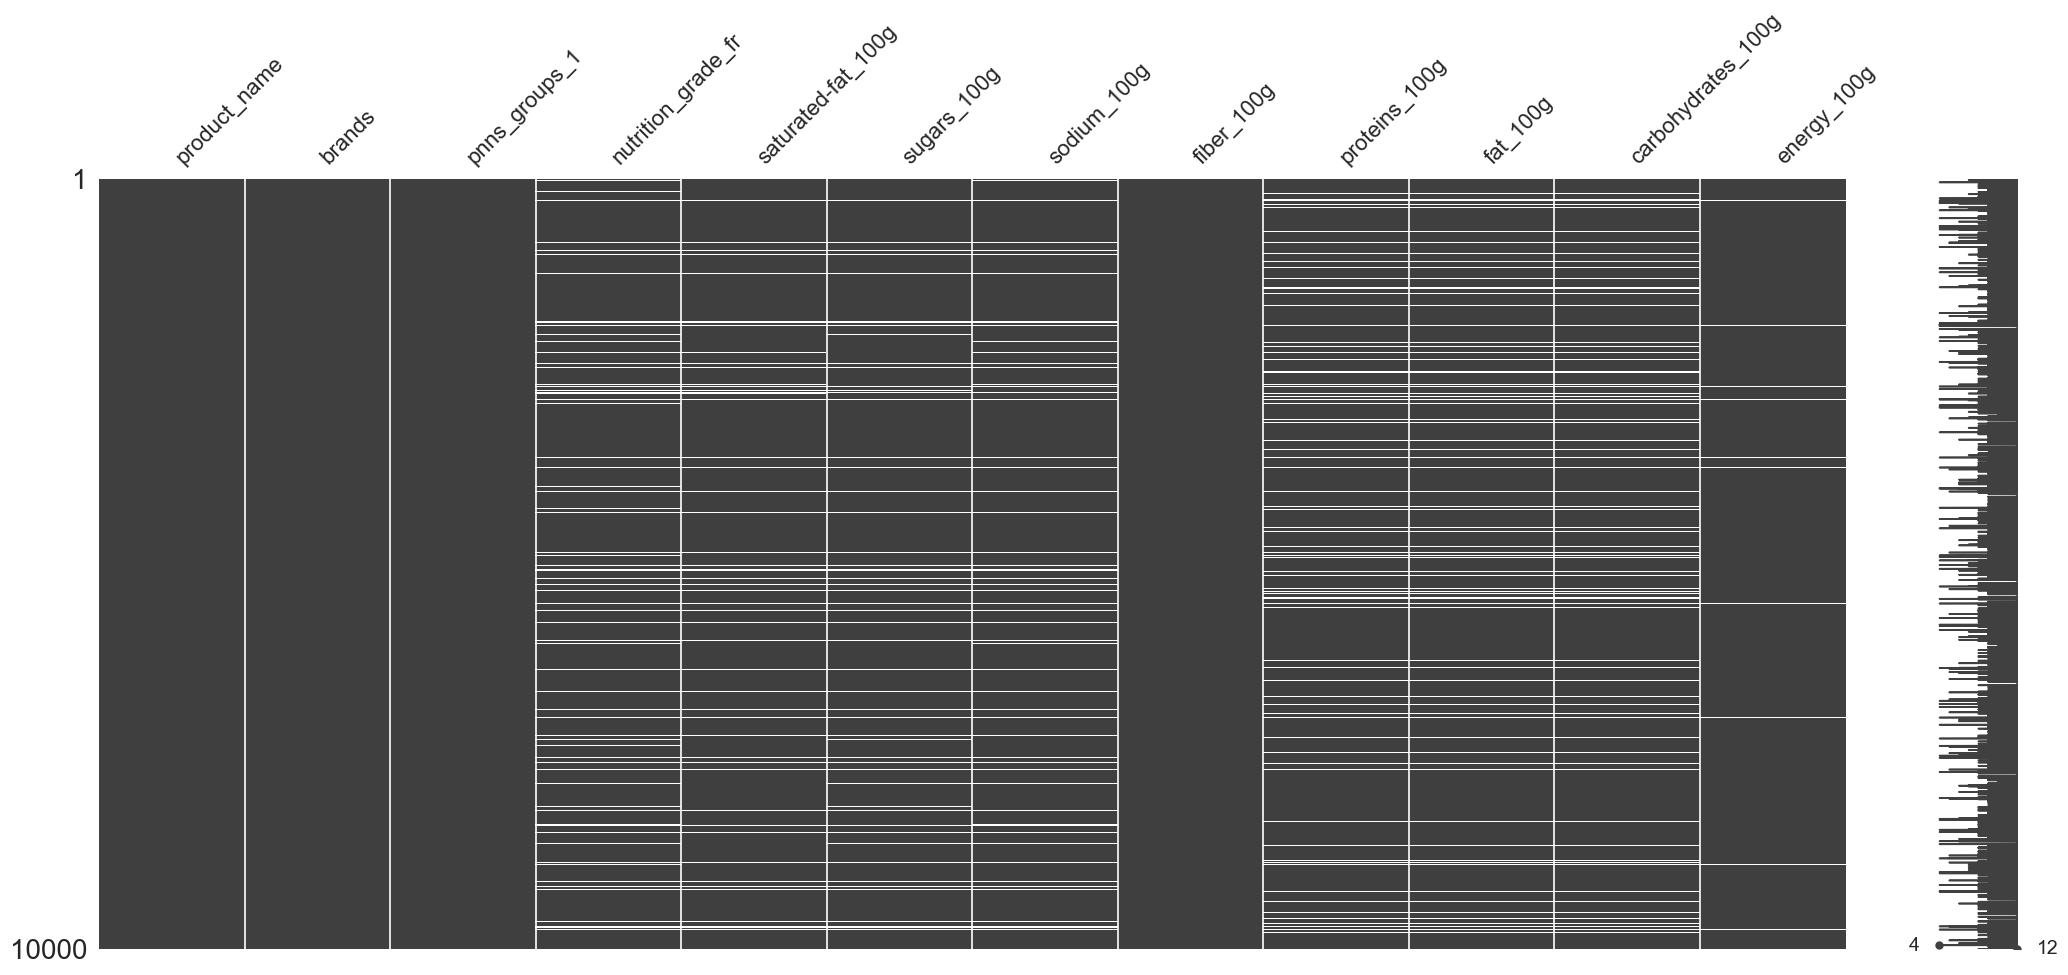

In [265]:
df_treat = subset.copy()

# Proportion missing values
null_ave = (df_treat.isnull().mean() * 100)
print("Percentage of Missing Values:")
print(null_ave)

# Nullity matrix
msno.matrix(df_treat.sample(10000))
plt.savefig(figures_path + 'nullity_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

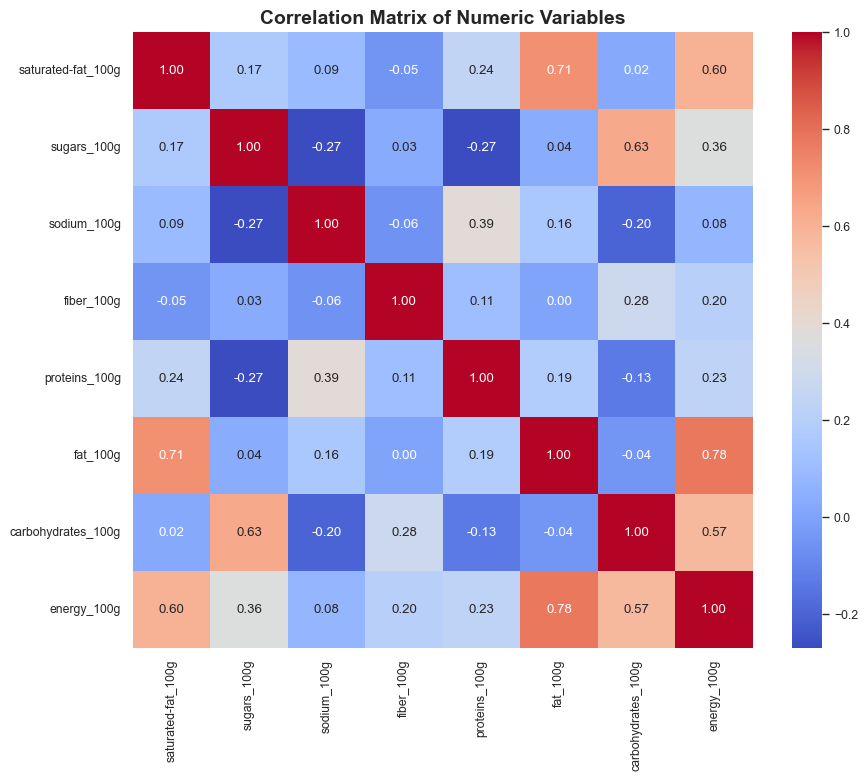

In [340]:
# Correlation between numeric variables
features = [
    'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 
    'fiber_100g', 'proteins_100g', 'fat_100g', 
    'carbohydrates_100g', 'energy_100g'
]

corr = df_treat[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Variables", fontsize=14, fontweight='bold')
plt.show()

#### Filling numeric values

In [312]:
# Fill numeric values using the KNN imputer
df_filled = df_treat.copy()

features = [
    'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 
    'fiber_100g', 'proteins_100g', 'fat_100g', 
    'carbohydrates_100g', 'energy_100g'
]

# Initialize and apply the KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_filled[features] = imputer.fit_transform(df_filled[features])

# Check that no missing values are left
missing_values_after = df_filled[features].isna().sum()
print("Missing values per column after final KNN imputation:")
print(missing_values_after)

Missing values per column after final KNN imputation:
saturated-fat_100g    0
sugars_100g           0
sodium_100g           0
fiber_100g            0
proteins_100g         0
fat_100g              0
carbohydrates_100g    0
energy_100g           0
dtype: int64


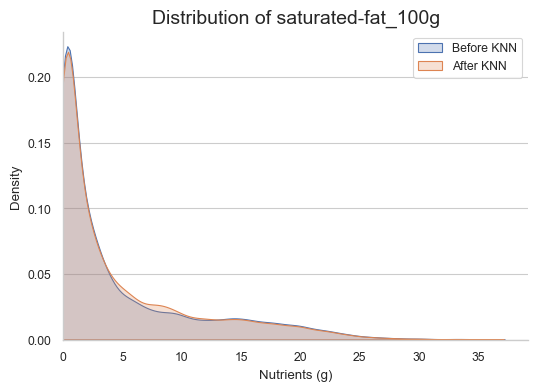

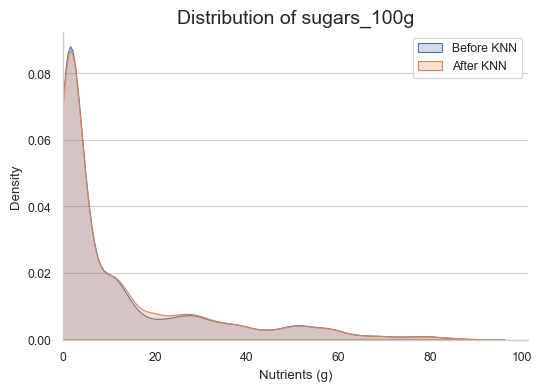

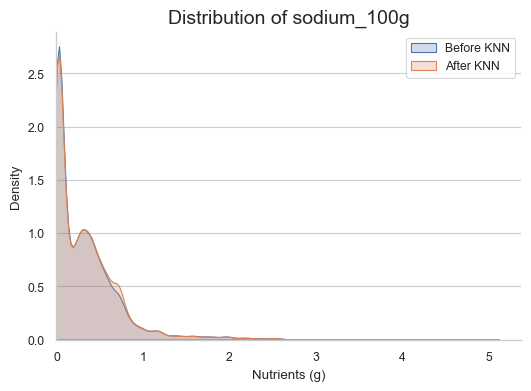

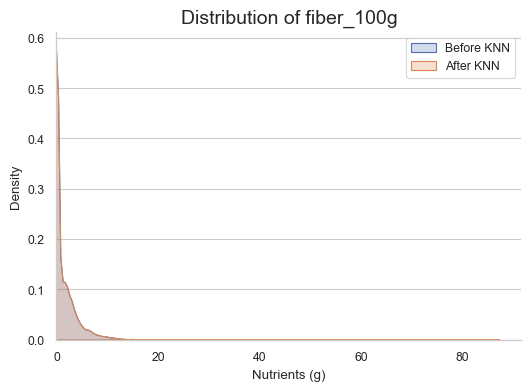

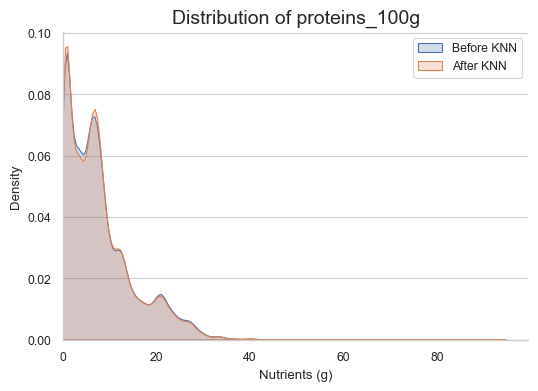

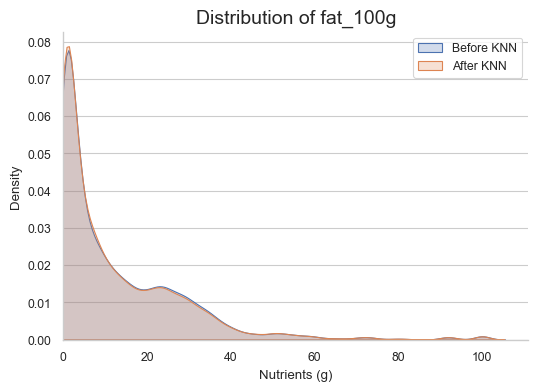

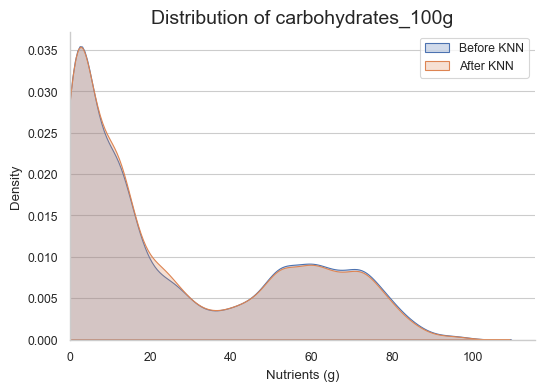

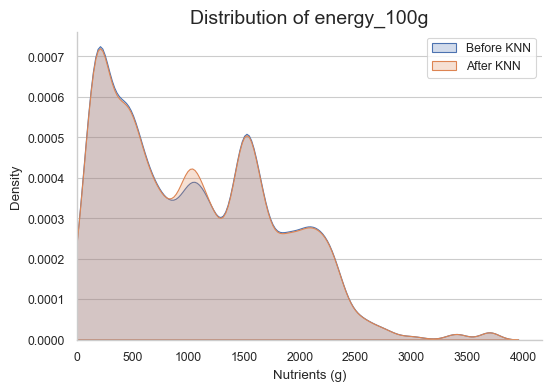

In [314]:
# KDE plot before and after KNN imputation
features = [
    'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 
    'fiber_100g', 'proteins_100g', 'fat_100g', 
    'carbohydrates_100g', 'energy_100g'
]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(df_treat[col].dropna(), label='Before KNN', fill=True)
    sns.kdeplot(df_filled[col].dropna(), label='After KNN', fill=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel('Nutrients (g)')
    plt.ylabel('Density')
    plt.xlim(0, None)
    sns.despine(right=True, top=True)
    plt.grid(False, axis='x')
    plt.legend()
    plt.savefig(f"{figures_path}kde_plot_for_knn_{col}.png", dpi=300)
    plt.show()

#### Filling categorical values

##### **Nutrition grade**

To fill the categorical variable nutrition_grade_fr, we need to run a model using KNeighborsClassifier on the non-na dataset to determine whether the nutrients accurately correspond to the scoring:
* Negative if high: 'saturated-fat_100g', 'sugars_100g', 'sodium_100g'
* Positive if high: 'fiber_100g', 'proteins_100g'

              precision    recall  f1-score   support

           a       0.78      0.84      0.81      2499
           b       0.62      0.62      0.62      1988
           c       0.68      0.70      0.69      2860
           d       0.78      0.78      0.78      3626
           e       0.85      0.77      0.81      2479

    accuracy                           0.75     13452
   macro avg       0.74      0.74      0.74     13452
weighted avg       0.75      0.75      0.75     13452



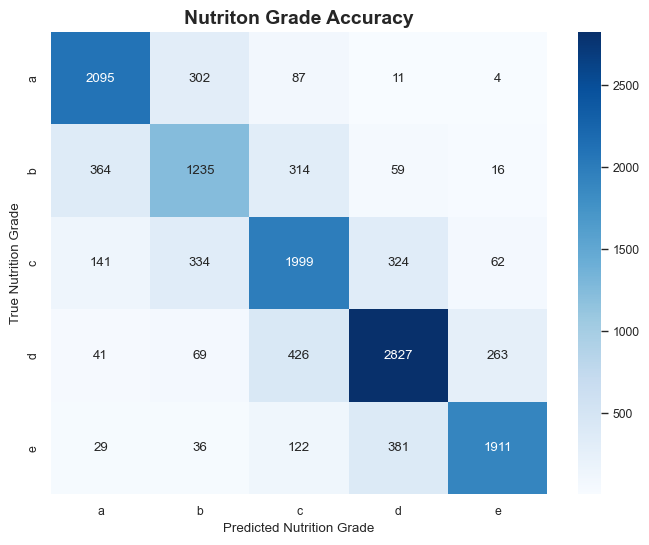

In [316]:
# Test nutrition_grade_fr model using KNeighborsClassifier
df_impute = df_filled[df_filled['nutrition_grade_fr'].notna()]

# Feature selection
X = df_impute[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', # negative if high
               'fiber_100g', 'proteins_100g']] # positive if high
y = df_impute['nutrition_grade_fr']

# Train the classifier
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) # Randomly split the data
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict and print results
y_pred = knn_clf.predict(X_val)
print(classification_report(y_val, y_pred))
matrix = confusion_matrix(y_val, y_pred, labels=knn_clf.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_clf.classes_, yticklabels=knn_clf.classes_)
plt.xlabel('Predicted Nutrition Grade')
plt.ylabel('True Nutrition Grade')
plt.title('Nutriton Grade Accuracy', fontsize=14, fontweight='bold')
plt.savefig(figures_path + 'nutrition_grade_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [318]:
# Use a KNeighborsClassifier model to replace nan category
train = df_filled[df_filled['nutrition_grade_fr'].notna()]
X_train = train[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']]
y_train = train['nutrition_grade_fr']

# Rows with missing nutrition_grade_fr for prediction
test = df_filled[df_filled['nutrition_grade_fr'].isna()]
X_test = test[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']]

# Train the classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict missing nutrition grades
predictions = knn_clf.predict(X_test)

# Fill the missing values in the original DataFrame
df_filled.loc[df_filled['nutrition_grade_fr'].isna(), 'nutrition_grade_fr'] = predictions

# Results
print(df_treat['nutrition_grade_fr'].value_counts(dropna=False))  # Before KNN
print(df_filled['nutrition_grade_fr'].value_counts(dropna=False))  # After KNN

nutrition_grade_fr
d      12196
c       9856
e       8252
a       8016
b       6520
NaN     3527
Name: count, dtype: int64
nutrition_grade_fr
d    13502
c    10953
e     8946
a     8295
b     6671
Name: count, dtype: int64


##### **PNNS Groups 'Unknown'**

To fill the categorical variable pnns_groups_1, we need to run a model using KNeighborsClassifier on the non 'unknown' dataset to determine whether the nutrients accurately correspond to the categories.

                         precision    recall  f1-score   support

              Beverages       0.86      0.87      0.86      1445
   Cereals and potatoes       0.81      0.81      0.81      1561
        Composite foods       0.71      0.77      0.74      1631
         Fat and sauces       0.73      0.65      0.69       783
         Fish Meat Eggs       0.85      0.85      0.85      1514
  Fruits and vegetables       0.76      0.67      0.71      1016
Milk and dairy products       0.83      0.88      0.86      1709
           Salty snacks       0.84      0.76      0.80       517
          Sugary snacks       0.90      0.90      0.90      2218

               accuracy                           0.82     12394
              macro avg       0.81      0.79      0.80     12394
           weighted avg       0.82      0.82      0.82     12394



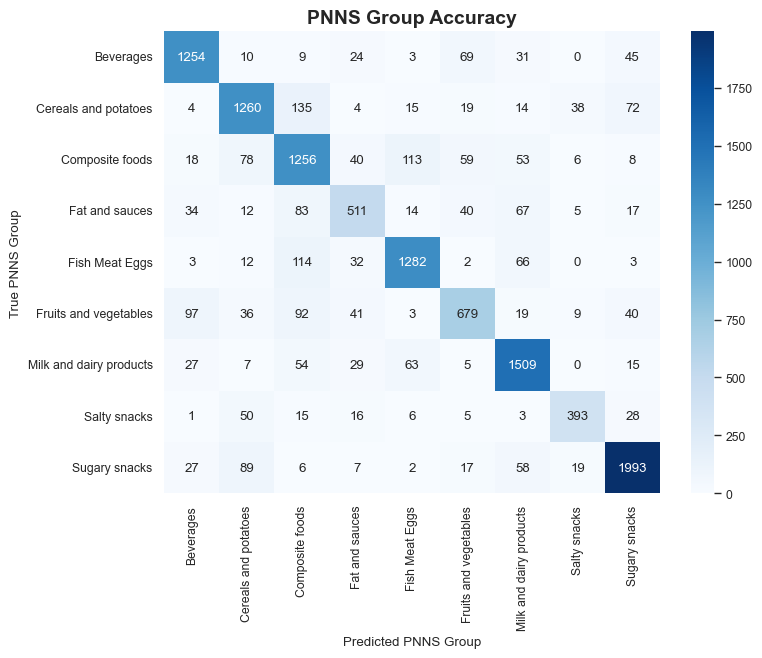

In [320]:
# Test pnns_groups_1 model using KNeighborsClassifier
df_impute = df_filled[df_filled['pnns_groups_1'] != 'unknown']

# Feature selection
X = df_impute[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 
               'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'energy_100g']]
y = df_impute['pnns_groups_1']

# Train the classifier
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict and print results
y_pred = knn_clf.predict(X_val)
print(classification_report(y_val, y_pred))
matrix = confusion_matrix(y_val, y_pred, labels=knn_clf.classes_)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_clf.classes_, yticklabels=knn_clf.classes_)
plt.xlabel('Predicted PNNS Group')
plt.ylabel('True PNNS Group')
plt.title('PNNS Group Accuracy', fontsize=14, fontweight='bold')
plt.savefig(figures_path + 'pnns_groups_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [324]:
# Use a KNeighborsClassifier model to replace 'unknown' category
df_filled.loc[df_filled['pnns_groups_1'] == 'unknown', 'pnns_groups_1'] = np.nan # make unknown nan

# Select rows where pnns_groups_1 is not missing for training
train = df_filled[df_filled['pnns_groups_1'].notna()]
X_train = train[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 
               'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'energy_100g']]
y_train = train['pnns_groups_1']

# Rows with missing nutrition_grade_fr for prediction
test = df_filled[df_filled['pnns_groups_1'].isna()]
X_test = test[['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 
               'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'energy_100g']]

# Train the classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict missing nutrition grades
predictions = knn_clf.predict(X_test)

# Fill the missing values in the original DataFrame
df_filled.loc[df_filled['pnns_groups_1'].isna(), 'pnns_groups_1'] = predictions

# Results
print(df_treat['pnns_groups_1'].value_counts(dropna=False))  # Before KNN
print(df_filled['pnns_groups_1'].value_counts(dropna=False))  # After KNN

pnns_groups_1
Sugary snacks              7511
unknown                    7055
Milk and dairy products    5763
Composite foods            5361
Cereals and potatoes       5273
Fish Meat Eggs             4990
Beverages                  4710
Fruits and vegetables      3367
Fat and sauces             2574
Salty snacks               1763
Name: count, dtype: int64
pnns_groups_1
Sugary snacks              9026
Composite foods            6713
Milk and dairy products    6585
Cereals and potatoes       6346
Fish Meat Eggs             5621
Beverages                  5125
Fruits and vegetables      3832
Fat and sauces             3103
Salty snacks               2016
Name: count, dtype: int64


### Handling duplicates

In [326]:
df_handle = df_filled.copy()

# Duplicate groups based on product_name and brands
id_cols = ['product_name', 'brands']
duplicate_groups = df_handle.duplicated(subset=id_cols, keep=False)
total_duplicates = duplicate_groups.sum()
print(f"Number of duplicate rows based on product_name and brands: {total_duplicates}")

# Columns for aggregation
numeric_cols = ['saturated-fat_100g', 'sugars_100g', 'sodium_100g', 
                'fiber_100g', 'proteins_100g', 'fat_100g', 
                'carbohydrates_100g', 'energy_100g']
mode_cols = ['pnns_groups_1', 'nutrition_grade_fr']

# Aggregation function
agg_funcs = {col: 'median' for col in numeric_cols}
agg_funcs.update({
    col: lambda x: x.dropna().mode().iloc[0] if not x.dropna().mode().empty else None
    for col in mode_cols
})

# Apply aggregation
df_no_duplicates = df_handle.groupby(id_cols).agg(agg_funcs).reset_index()

# Results
original_count = len(df_handle)
new_count = len(df_no_duplicates)
duplicates_removed = original_count - new_count
print(f"Number of duplicate rows removed: {duplicates_removed}")

Number of duplicate rows based on product_name and brands: 3151
Number of duplicate rows removed: 1773


## Export

In [327]:
# Export as csv
df_no_duplicates.to_csv(data_path_processed + 'processed_df.csv', index=False)
df_no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46594 entries, 0 to 46593
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_name        46594 non-null  object 
 1   brands              46594 non-null  object 
 2   saturated-fat_100g  46594 non-null  float64
 3   sugars_100g         46594 non-null  float64
 4   sodium_100g         46594 non-null  float64
 5   fiber_100g          46594 non-null  float64
 6   proteins_100g       46594 non-null  float64
 7   fat_100g            46594 non-null  float64
 8   carbohydrates_100g  46594 non-null  float64
 9   energy_100g         46594 non-null  float64
 10  pnns_groups_1       46594 non-null  object 
 11  nutrition_grade_fr  46594 non-null  object 
dtypes: float64(8), object(4)
memory usage: 4.3+ MB


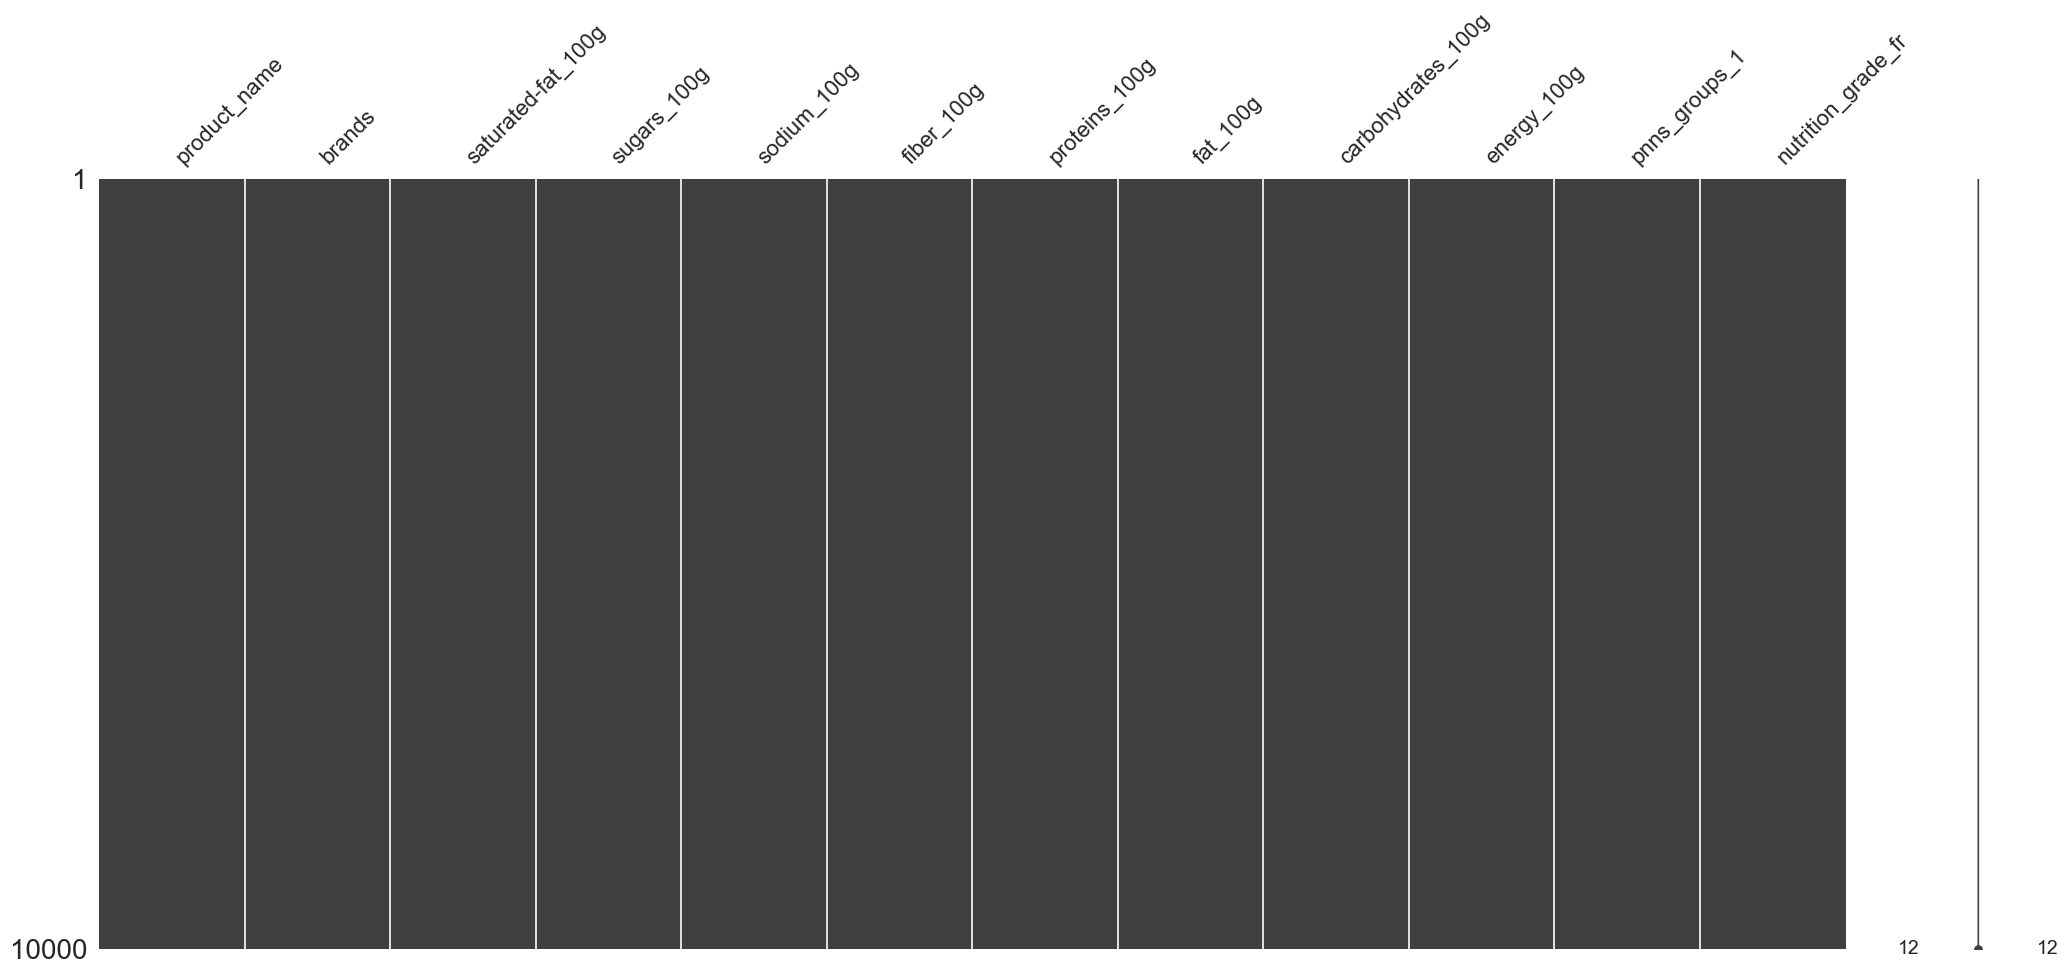

In [330]:
# Nullity matrix
msno.matrix(df_no_duplicates.sample(10000))
plt.savefig(figures_path + 'nullity_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()